<a href="https://colab.research.google.com/github/jonkrohn/DLTFpT/blob/master/notebooks/dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Activity Classifier

In this notebook, we build a dense neural net to classify PE activity.

#### Load dependencies

In [8]:
import tensorflow
from tensorflow.keras.datasets import imdb # new!  # delete later
from tensorflow.keras.preprocessing.sequence import pad_sequences #new!
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding # new!
from tensorflow.keras.callbacks import ModelCheckpoint # new! 
import os # new! 
from sklearn.metrics import roc_auc_score, roc_curve # new!
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # new!

In [9]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()
import tensorflow as tf
print("# GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tensorflow.__version__

# GPUs Available:  1


'2.3.0'

#### Set hyperparameters

In [10]:
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# encoder.fit(label_array)
# encoder.categories_

# label_array.shape

In [11]:
# output directory name:
output_dir = 'model_output/dense'
input_dir =  'Z:/Research/dfuller/Walkabilly/studies/smarphone_accel/data/Ethica_Jaeger_Merged/pocket/'
input_file_name = 'pocket-NN-data.npz'

# from the data preparation section we have:
window_size_second = 3
frequency = 30
lenght_of_each_seq = window_size_second * frequency




# convolutional layer architecture:
n_conv = 64 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

# training:
epochs = 3
batch_size = 128


#### Load data

##### For this notebook we use the acceleration data gathered from the pocket location. It was prepared in the DataPrep-Deep notebook

In [12]:
# read the raw file and get the keys:
raw_data = np.load(file=input_dir+input_file_name,allow_pickle=True)
for k in raw_data.keys():
    print(k)

acceleration_data
metadata
labels


In [13]:
# import the data

accel_array = raw_data['acceleration_data']
meta_array = raw_data['metadata']
labels_array = raw_data['labels']


#### Preprocess data

#### Convert the  labels to integer.
In the raw data format of the labels is String and there are 6 classes. 'Lying', 'Sitting', 'Self Pace walk', 'Running 3 METs',
       'Running 5 METs', 'Running 7 METs' <br>




In [15]:
# change from string to integer so keras.to_categorical can consume it

# could do with factorize method as well
n_class = len(np.unique(labels_array))
class_list, labels_array_int = np.unique(labels_array,return_inverse=True)
labels_array_int

# check if the result is consistant with the original input
class_list[labels_array_int].reshape(len(labels_array_int), 1) == labels_array

# Note to get the reverse, i.e converting integer array to string use class_list[labels_array_int]

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [16]:
# labels to categorical

y = to_categorical(labels_array_int, num_classes=n_class)
input_shape = list(accel_array.shape)


#### Design neural network architecture

In [17]:
# a conv model!

model = Sequential()
model.add(Conv1D(n_conv, k_conv, activation='relu', input_shape=input_shape[1:]))
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_class, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 88, 64)            640       
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 1

### Splitting and shuffeling the data

In [19]:
# split and shuffle
x_train, x_valid, y_train, y_valid = train_test_split(
     accel_array, y, test_size=0.1, random_state=65)

#### Configure model

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [21]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+
                                  "/weights.{epoch:02d}.hdf5")

In [22]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [23]:
import tensorflow as tf
tf.test.gpu_device_name()
tf.__version__
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((63352, 90, 3), (63352, 6), (7040, 90, 3), (7040, 6))

#### Train!

In [24]:
model.fit(x_train, y_train, 
         batch_size=batch_size, epochs=epochs, verbose=1, 
         validation_data=(x_valid, y_valid), 
         callbacks=[modelcheckpoint])

# model.fit(x_train, y_train, 
#           batch_size=batch_size, epochs=epochs, verbose=1, 
#           validation_data=(x_valid, y_valid))

Epoch 1/3
495/495 [==============================] - 2s 4ms/step - loss: 0.9665 - accuracy: 0.6149 - val_loss: 0.6707 - val_accuracy: 0.7499
Epoch 2/3
495/495 [==============================] - 2s 3ms/step - loss: 0.6514 - accuracy: 0.7610 - val_loss: 0.5472 - val_accuracy: 0.7905
Epoch 3/3
495/495 [==============================] - 2s 4ms/step - loss: 0.5519 - accuracy: 0.8038 - val_loss: 0.4758 - val_accuracy: 0.8212


In [20]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


#### Evaluate

In [ ]:
# model.load_weights(output_dir+"/weights.02.hdf5") # NOT zero-indexed

In [237]:
y_hat = model.predict(x_valid)

In [238]:
len(y_hat)

7040

In [239]:
y_hat[0]

array([2.3900741e-01, 2.3661785e-07, 2.7467215e-07, 3.5306093e-05,
       1.0925921e-09, 7.6095676e-01], dtype=float32)

In [240]:
y_valid[0]

array([0., 0., 0., 0., 0., 1.], dtype=float32)

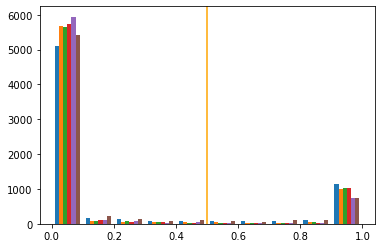

In [241]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [242]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [243]:
"{:0.2f}".format(pct_auc)

'99.40'

In [244]:
float_y_hat = []
for y in y_hat:
    float_y_hat.append(y[0])

In [245]:
ydf = pd.DataFrame(list(zip(float_y_hat, y_valid)), columns=['y_hat', 'y'])

In [246]:
ydf.head(10)

y_hat                               y
0  2.390074e-01  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
1  4.455001e-04  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
2  6.522904e-03  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
3  2.519241e-10  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
4  9.942215e-01  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
5  2.289968e-03  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
6  4.869331e-01  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
7  1.000041e-02  [0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
8  1.545678e-01  [0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
9  6.445088e-01  [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]